# Single qubit GST on the 5 qubit chip (Data from 3.5.2023)

In [1]:
# Note: I removed the mGST folders from within the qibocal fork, such that it is installed and updated seperately
from mGST import compatibility,algorithm, optimization, low_level_jit, additional_fns

In [41]:
import pickle as pickle
from pygsti.report import reportables as rptbl #Needs cvxpy!
from pygsti.modelpacks import smq1Q_XYI as std
import pygsti
from argparse import Namespace
import numpy as np
import pandas as pd
import numpy.linalg as la
import json
import matplotlib.pyplot as plt

### Setting the parameters

In [3]:
pdim = 2   # physical dimension
r = pdim**2   # rank of the gate superoperators 

l = 7  # maximum number of gates in each measurement sequence
d = 3  # number of gates
rK = 1   # rank of the model estimate
n_povm = 2   # number of POVM-elements

meas_samples = 1e4

### Loading data

In [4]:
with open('data/qw5q-qubit1-fast.json') as f:
    data = json.load(f)
print(data.keys())
J = np.array(data['sequences'])
y = np.array(data['hardware_probabilities']).T

dict_keys(['nsequences', 'sequence_creation_time', 'execution_time', 'sequences', 'hardware_probabilities', 'platform', 'qubit', 'depth', 'nshots'])


### GST

Starting optimization...
 26%|███████████▏                               | 13/50 [00:02<00:07,  4.95it/s]


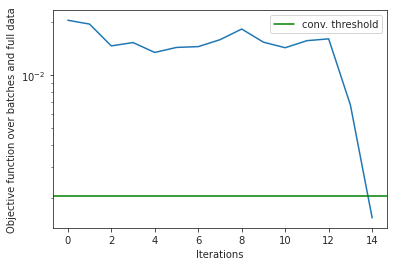

Optimization successful, improving estimate over full data....
  9%|███▊                                        | 7/80 [00:01<00:18,  4.00it/s]


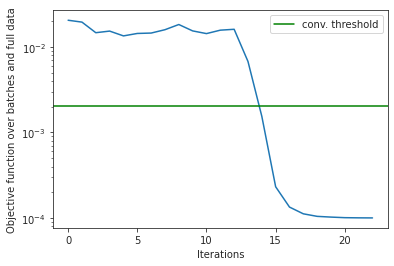

#################
	 Convergence criterion satisfied
	 Final objective function value 0.00010028756882133168 with # of initializations: 1 
 	 Total runtime: 4.8227174282073975


In [5]:
bsize = 50   # The batch size on which the optimization is started
X_t,E_t,rho_t = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'std') #The idle-X(pi/w)-Y(pi/2) model 
K_t = additional_fns.Kraus_rep(X_t,d,pdim,rK)
X_t = np.einsum('ijkl,ijnm -> iknlm', K_t, K_t.conj()).reshape(d,r,r)  
K,X,E,rho,res_list = algorithm.run_mGST(y,J,l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
                     max_inits = 20, max_iter = 50, final_iter = 80, threshold_multiplyer = 100, 
                     target_rel_prec = 1e-4, init = [K_t,E_t,rho_t], testing = True)   

In [34]:
X_pp, E_pp, rho_pp = compatibility.std2pp(X,E,rho)

(array([[[ 1.00000000e+00+0.j, -3.74608756e-16+0.j, -2.90909989e-16+0.j,
           1.44252388e-16+0.j],
         [-3.29854473e-16+0.j,  9.89945921e-01+0.j, -1.41446193e-01+0.j,
          -2.18604351e-04+0.j],
         [-3.43166011e-16+0.j,  1.41432188e-01+0.j,  9.89867422e-01+0.j,
          -1.26262924e-02+0.j],
         [ 6.17126315e-17+0.j,  2.00233031e-03+0.j,  1.24684289e-02+0.j,
           9.99920261e-01+0.j]],
 
        [[ 1.00000000e+00+0.j, -2.80939923e-16+0.j,  6.01339466e-16+0.j,
          -4.48421127e-16+0.j],
         [-6.97024810e-17+0.j,  9.37792599e-01+0.j,  3.44557085e-01+0.j,
           4.27253583e-02+0.j],
         [ 4.06364048e-16+0.j,  3.41036943e-02+0.j,  3.10476944e-02+0.j,
          -9.98935923e-01+0.j],
         [ 6.76280351e-16+0.j, -3.45516974e-01+0.j,  9.38251808e-01+0.j,
           1.73656285e-02+0.j]],
 
        [[ 1.00000000e+00+0.j, -2.21038672e-17+0.j, -6.21592626e-17+0.j,
           5.30253996e-16+0.j],
         [ 4.80062417e-16+0.j,  3.91520252e-02+0.

In [35]:
def gauge_opt_report(X, E, rho, J, y, weights):
    mdl = compatibility.arrays_to_pygsti_model(X,E,rho, basis = 'std')
    X_t,E_t,rho_t = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'std')
    target_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std') #For consistent gate labels

    gauge_optimized_mdl = pygsti.algorithms.gaugeopt_to_target(mdl, 
                target_mdl,gauge_group = pygsti.models.gaugegroup.UnitaryGaugeGroup(target_mdl.state_space, basis = 'pp'),
                item_weights=weights)
    X_opt,E_opt,rho_opt = compatibility.pygsti_model_to_arrays(gauge_optimized_mdl,basis = 'std')    
    
    final_objf = low_level_jit.objf(X,E,rho,J,y)
    data_tvd = additional_fns.tvd(X,E,rho,J,y)
    MVE = additional_fns.MVE(X_t,E_t,rho_t,X,E,rho,d,l, n_povm)[0]
    povm_td = rptbl.povm_jtrace_diff(target_mdl, gauge_optimized_mdl, 'Mdefault')
    rho_td = la.norm(rho_opt-rho_t,ord = 1)/2
    F_avg = compatibility.average_gate_fidelities(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp')
    DD = compatibility.diamond_dists(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp')
    

    df_g = pd.DataFrame({
        "F_avg":F_avg,
        "Diamond distances": DD
    })
    df_o = pd.DataFrame({
        "Final cost function value": final_objf,
        "Total variation dist. to data": data_tvd,
        "Mean total variation dist. to target": MVE,
        "POVM - Choi map trace distance": povm_td,
        "State - Trace distance": rho_td,  
    }, index = [0])
    df_g.rename(index={0: "Id", 1: "Rx(pi/2)", 2: "Ry(pi/2)"}, inplace = True)
    df_o.rename(index={0: ""}, inplace = True)
    
    s_g = df_g.style.format(precision=5, thousands=".", decimal=",")
    s_o = df_o.style
    
    s_g.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: center;'},
    {'selector': 'th.col_heading.level0', 'props': 'font-size: 1em;'},
    {'selector': 'td', 'props': 'text-align: center'},
    ], overwrite=False)
    s_o.set_table_styles([
    {'selector': 'th.col_heading', 'props': 'text-align: center;'},
    {'selector': 'th.col_heading.level0', 'props': 'font-size: 1em;'},
    {'selector': 'td', 'props': 'text-align: center'},
    ], overwrite=False)
    return df_g, df_o, s_g, s_o, gauge_optimized_mdl

In [37]:
df_g, df_o, s_g, s_o, gauge_optimized_mdl = gauge_opt_report(X, E, rho, J, y, weights = {'G0': 1,'G1': 1, 'G2': 1, 'spam': 1})
X_pp, E_pp, rho_pp = compatibility.pygsti_model_to_arrays(gauge_optimized_mdl,basis = 'pp')
display(s_g), display(s_o)

,F_avg,Diamond distances
Id,"0,99662","0,07118"
Rx(pi/2),"0,99986","0,01430"
Ry(pi/2),"0,99991","0,01143"


,Final cost function value,Total variation dist. to data,Mean total variation dist. to target,POVM - Choi map trace distance,State - Trace distance
,0.000100,0.037851,0.124587,0.106001,0.120592


(None, None)

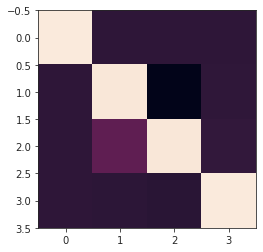

In [42]:
plt.imshow(np.real(X_pp)[0])

In [21]:
#Quibit 1 fast
MVE_list = []
povm_td_list = []
rho_td_list = []
F_avg_list = []
DD_list = []

mdl = compatibility.arrays_to_pygsti_model(X,E,rho, basis = 'std')
X_t,E_t,rho_t = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'std')
#X_t = X_t[1:,:,:]
target_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std') #For consistent gate labels

gauge_optimized_mdl = pygsti.algorithms.gaugeopt_to_target(mdl, 
            target_mdl,gauge_group = pygsti.models.gaugegroup.UnitaryGaugeGroup(target_mdl.state_space, basis = 'pp'),
            item_weights={'G0': 1,'G1': 1, 'G2': 1, 'spam': 1})
X_opt,E_opt,rho_opt = compatibility.pygsti_model_to_arrays(gauge_optimized_mdl,basis = 'std')

MVE_list.append(additional_fns.MVE(X_t,E_t,rho_t,X,E,rho,d,l, n_povm)[0])
povm_td_list.append(rptbl.povm_jtrace_diff(target_mdl, gauge_optimized_mdl, 'Mdefault'))
rho_td_list.append(la.norm(rho_opt-rho_t,ord = 1)/2)
F_avg_list.append(compatibility.average_gate_fidelities(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp'))
DD_list.append(compatibility.diamond_dists(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp'))
print('Mean variation error between GST-model probabilities and target model probabilities:', MVE_list[-1])   # output the final mean variation error
print('Initial state error in trace distance:', rho_td_list[-1])
print('Choi matrix trace distance of the measurement map:',povm_td_list[-1])
print('Average gate fidelities:',F_avg_list[-1])
print('Diamond distances:',DD_list[-1])
print('\n')

Mean variation error between GST-model probabilities and target model probabilities: 0.1277086708855956
Initial state error in trace distance: 0.03592697225814834
Choi matrix trace distance of the measurement map: 0.09988458172644818
Average gate fidelities: [0.98392854 0.98864959 0.98259755]
Diamond distances: [0.08069606 0.03780544 0.03895751]




In [15]:
#Quibit 2 fast
MVE_list = []
povm_td_list = []
rho_td_list = []
F_avg_list = []
DD_list = []

mdl = compatibility.arrays_to_pygsti_model(X,E,rho, basis = 'std')
X_t,E_t,rho_t = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'std')
#X_t = X_t[1:,:,:]
target_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std') #For consistent gate labels

gauge_optimized_mdl = pygsti.algorithms.gaugeopt_to_target(mdl, 
            target_mdl,gauge_group = pygsti.models.gaugegroup.UnitaryGaugeGroup(target_mdl.state_space, basis = 'pp'),
            item_weights={'G0': 1,'G1': 1, 'G2': 1, 'spam': 1})
X_opt,E_opt,rho_opt = compatibility.pygsti_model_to_arrays(gauge_optimized_mdl,basis = 'std')

MVE_list.append(additional_fns.MVE(X_t,E_t,rho_t,X,E,rho,d,l, n_povm)[0])
povm_td_list.append(rptbl.povm_jtrace_diff(target_mdl, gauge_optimized_mdl, 'Mdefault'))
rho_td_list.append(la.norm(rho_opt-rho_t,ord = 1)/2)
F_avg_list.append(compatibility.average_gate_fidelities(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp'))
DD_list.append(compatibility.diamond_dists(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp'))
print('Mean variation error between GST-model probabilities and target model probabilities:', MVE_list[-1])   # output the final mean variation error
print('Initial state error in trace distance:', rho_td_list[-1])
print('Choi matrix trace distance of the measurement map:',povm_td_list[-1])
print('Average gate fidelities:',F_avg_list[-1])
print('Diamond distances:',DD_list[-1])
print('\n')

Mean variation error between GST-model probabilities and target model probabilities: 0.12148038334583623
Initial state error in trace distance: 0.07377992876941701
Choi matrix trace distance of the measurement map: 0.09082708866662206
Average gate fidelities: [0.98435467 0.99091956 0.98875253]
Diamond distances: [0.11543687 0.03397122 0.04296556]




In [18]:
#Quibit 3 fast
MVE_list = []
povm_td_list = []
rho_td_list = []
F_avg_list = []
DD_list = []

mdl = compatibility.arrays_to_pygsti_model(X,E,rho, basis = 'std')
X_t,E_t,rho_t = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'std')
#X_t = X_t[1:,:,:]
target_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std') #For consistent gate labels

gauge_optimized_mdl = pygsti.algorithms.gaugeopt_to_target(mdl, 
            target_mdl,gauge_group = pygsti.models.gaugegroup.UnitaryGaugeGroup(target_mdl.state_space, basis = 'pp'),
            item_weights={'G0': 1,'G1': 1, 'G2': 1, 'spam': 1})
X_opt,E_opt,rho_opt = compatibility.pygsti_model_to_arrays(gauge_optimized_mdl,basis = 'std')

MVE_list.append(additional_fns.MVE(X_t,E_t,rho_t,X,E,rho,d,l, n_povm)[0])
povm_td_list.append(rptbl.povm_jtrace_diff(target_mdl, gauge_optimized_mdl, 'Mdefault'))
rho_td_list.append(la.norm(rho_opt-rho_t,ord = 1)/2)
F_avg_list.append(compatibility.average_gate_fidelities(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp'))
DD_list.append(compatibility.diamond_dists(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp'))
print('Mean variation error between GST-model probabilities and target model probabilities:', MVE_list[-1])   # output the final mean variation error
print('Initial state error in trace distance:', rho_td_list[-1])
print('Choi matrix trace distance of the measurement map:',povm_td_list[-1])
print('Average gate fidelities:',F_avg_list[-1])
print('Diamond distances:',DD_list[-1])
print('\n')

Mean variation error between GST-model probabilities and target model probabilities: 0.0596533803152623
Initial state error in trace distance: 0.04022200820103058
Choi matrix trace distance of the measurement map: 0.038545848242258166
Average gate fidelities: [0.99391305 0.99050259 0.98980255]
Diamond distances: [0.03662646 0.02219672 0.02327924]




In [8]:
#Quibit 1 with assumed perfect identity
MVE_list = []
povm_td_list = []
rho_td_list = []
F_avg_list = []
DD_list = []

mdl = compatibility.arrays_to_pygsti_model(X,E,rho, basis = 'std')
X_t,E_t,rho_t = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'std')
X_t = X_t[1:,:,:]
target_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std') #For consistent gate labels

gauge_optimized_mdl = pygsti.algorithms.gaugeopt_to_target(mdl, 
            target_mdl,gauge_group = pygsti.models.gaugegroup.UnitaryGaugeGroup(target_mdl.state_space, basis = 'pp'),
            item_weights={'G0': 1,'G1': 1, 'G2': 1, 'spam': 1})
X_opt,E_opt,rho_opt = compatibility.pygsti_model_to_arrays(gauge_optimized_mdl,basis = 'std')

MVE_list.append(additional_fns.MVE(X_t,E_t,rho_t,X,E,rho,d,l, n_povm)[0])
povm_td_list.append(rptbl.povm_jtrace_diff(target_mdl, gauge_optimized_mdl, 'Mdefault'))
rho_td_list.append(la.norm(rho_opt-rho_t,ord = 1)/2)
F_avg_list.append(compatibility.average_gate_fidelities(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp'))
DD_list.append(compatibility.diamond_dists(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp'))
print('Total variation error between model probabilites and measured probabilites (goodness of fit):', rho_td_list[-1])
print('Mean variation error between GST-model probabilities and target model probabilities:', MVE_list[-1])   # output the final mean variation error
print('Initial state error in trace distance:', rho_td_list[-1])
print('Choi matrix trace distance of the measurement map:',povm_td_list[-1])
print('Average gate fidelities:',F_avg_list[-1])
print('Diamond distances:',DD_list[-1])
print('\n')

Total variation error between model probabilites and measured probabilites (goodness of fit): 0.06004875370121403
Mean variation error between GST-model probabilities and target model probabilities: 0.1460433061492678
Initial state error in trace distance: 0.06004875370121403
Choi matrix trace distance of the measurement map: 0.15824189669461425
Average gate fidelities: [0.99341975 0.98399095]
Diamond distances: [0.03651771 0.03967445]




###  Saving data

In [11]:
###################################### 
# filename = 'ranks_1_4_full_data_from_init'
# parameters = {'sequence length':l,'gate count':d,'Kraus ranks':[1,2,3,4],'phys. dimension':int(np.sqrt(r)), 'Sequence count': N, 
#               'J':J,'y':y,'threshold_multiplyer': 30, 
#                      'target_rel_prec':1e-4}
# data_to_safe = {'parameters':parameters, 'results':results}

# with open(filename, 'wb') as handle:
#     pickle.dump(data_to_safe, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Analysis of results and comparison over different runs

In [17]:
# with open("ranks_1_4_full_data_from_init", 'rb') as handle:
#     b = pickle.load(handle)
# results = b['results']

In [18]:
MVE_list = []
povm_td_list = []
rho_td_list = []
F_avg_list = []
DD_list = []
for i in range(len(results)):
    X,E,rho = results[i][1:]
    mdl = arrays_to_pygsti_model(X,E,rho, basis = 'std')
    X_t,E_t,rho_t = pygsti_model_to_arrays(std.target_model(),basis = 'std')
    target_mdl = arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std') #For consistent gate labels

    gauge_optimized_mdl = pygsti.algorithms.gaugeopt_to_target(mdl, 
                target_mdl,gauge_group = pygsti.models.gaugegroup.UnitaryGaugeGroup(target_mdl.state_space, basis = 'pp'),
                item_weights={'G0': 1,'G1': 1, 'G2': 1, 'spam': 1})
    X_opt,E_opt,rho_opt = pygsti_model_to_arrays(gauge_optimized_mdl,basis = 'std')

    MVE_list.append(MVE(X_t,E_t,rho_t,X,E,rho,d,l, n_povm)[0])
    povm_td_list.append(rptbl.povm_jtrace_diff(target_mdl, gauge_optimized_mdl, 'Mdefault'))
    rho_td_list.append(la.norm(rho_opt-rho_t,ord = 1)/2)
    F_avg_list.append(average_gate_fidelities(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp'))
    DD_list.append(diamond_dists(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp'))
    print('Total variation error between model probabilites and measured probabilites (goodness of fit):', rho_td_list[-1])
    print('Mean variation error between GST-model probabilities and target model probabilities:', MVE_list[-1])   # output the final mean variation error
    print('Initial state error in trace distance:', rho_td_list[-1])
    print('Choi matrix trace distance of the measurement map:',povm_td_list[-1])
    print('Average gate fidelities:',F_avg_list[-1])
    print('Diamond distances:',DD_list[-1])
    print('\n')

Total variation error between model probabilites and measured probabilites (goodness of fit): 0.08446669343064618
Mean variation error between GST-model probabilities and target model probabilities: 0.044625168861381743
Initial state error in trace distance: 0.08446669343064618
Choi matrix trace distance of the measurement map: 0.028666874686050777
Average gate fidelities: [0.99999672 0.99995954 0.99996703]
Diamond distances: [0.00221649 0.00779018 0.00703208]


Total variation error between model probabilites and measured probabilites (goodness of fit): 0.014228750982740422
Mean variation error between GST-model probabilities and target model probabilities: 0.044036727323747686
Initial state error in trace distance: 0.014228750982740422
Choi matrix trace distance of the measurement map: 0.012587991063289833
Average gate fidelities: [0.99159996 0.98313685 0.98286903]
Diamond distances: [0.01349505 0.02837346 0.02692042]


Total variation error between model probabilites and measured pr